In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pyro import distributions as dist
from pyrofit.lensing.utils import get_meshgrid
from pyrofit.lensing.lenses import SPLELens
from pyrofit.lensing.sources import SersicSource

torch.cuda.set_device(0)
torch.set_default_tensor_type(torch.cuda.FloatTensor)

import swyft

DEVICE='cuda'

In [2]:
SIGMA = 1.0

In [3]:
def image_generator(x, y, phi, q, r_ein, slope, x_src, y_src, phi_src, q_src, index, r_e, I_e):

    res = 0.0125*8                      # resolution in arcsec
    nx, ny = 50, 50                   # number of pixels
    X, Y = get_meshgrid(res, nx, ny)    # grid

    # Lens
    lens = SPLELens(device=DEVICE)
    lens.XY = X,Y
    # Displacement field
    alphas = lens(x=x, y=y, phi=phi, q=q, r_ein=r_ein, slope=slope)

    # Lensing equation
    X_src = X - alphas[..., 0, :, :]
    Y_src = Y - alphas[..., 1, :, :]

    # Source
    sersic = SersicSource(device=DEVICE)

    # Lensed source
    image = sersic(X=X_src, Y=Y_src, x=x_src, y=y_src, phi=phi_src, q=q_src, index=index, r_e=r_e, I_e=I_e)
    
    return image.cpu().numpy()

In [4]:
def model(v):
    # Lens parameters
    x = -0.05
    y = 0.1
    phi = 1.
    q = 0.5
    #r_ein = 1.4
    slope = 2.1
    #x, y, phi, q, r_ein, slope, x_src, y_src, phi_src, q_src, index, r_e, I_e = v
    r_ein = v[0]
    
    # Source param
    x_src = 0.
    y_src = 0.
    phi_src = 1.5
    q_src =0.7
    index = 2.
    r_e = 1.5
    I_e = 1.
    
    img = image_generator(x, y, phi, q, r_ein, slope, x_src, y_src, phi_src, q_src, index, r_e, I_e)
    return dict(img = img)

In [5]:
def noise(sim, v, sigma = SIGMA):
    return dict(img = sim['img'] + np.random.randn(50, 50)*sigma)

In [6]:
low =  np.array([1.38])
high = np.array([1.42])
prior = swyft.get_uniform_prior(low, high)

In [7]:
sim = swyft.Simulator(model, 1, dict(img=(50,50)))

In [8]:
Ntrain = 3000

store = swyft.Store.memory_store(sim)
store.add(Ntrain, prior)
store.simulate()

Creating new store.
Store: Adding 3049 new samples to simulator store.


In [9]:
torch.set_default_tensor_type(torch.FloatTensor)  # Needing this is kinda stupid

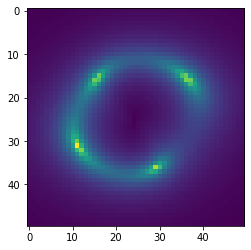

In [10]:
plt.imshow(store[4][0]['img'])

In [11]:
dataset = swyft.Dataset(Ntrain, prior, store, simhook = noise)

In [12]:
class CustomObservationTransform(torch.nn.Module):
    def __init__(self, observation_key: str, observation_shapes: dict):
        super().__init__()
        self.observation_key = observation_key
        self.n_features = 160  # This attribute must be defined!
        
        self.online_z_score = swyft.networks.OnlineDictStandardizingLayer(observation_shapes)
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(10, 20, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(20, 40, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Flatten(),
            torch.nn.Linear(640, 160),
        )

    def forward(self, obs: dict) -> torch.Tensor:
        x = self.online_z_score(obs)
        x = x[self.observation_key]
        x = x.unsqueeze(1)
        x = self.net(x).squeeze(1)
        return x

def get_custom_marginal_classifier(
    observation_transform,
    marginal_indices: tuple,
    n_parameters: int,
    hidden_features: int,
    num_blocks: int,
    marginal_classifier = None,
    parameter_online_z_score: bool = True,
) -> torch.nn.Module:
    n_observation_features = observation_transform.n_features

    parameter_transform = swyft.networks.ParameterTransform(
        n_parameters, marginal_indices, online_z_score=parameter_online_z_score
    )
    n_marginals, n_block_parameters = parameter_transform.marginal_block_shape

    if marginal_classifier is None:
        marginal_classifier = swyft.networks.MarginalClassifier(
            n_marginals,
            n_observation_features + n_block_parameters,
            hidden_features=hidden_features,
            num_blocks=num_blocks,
        )
    else:
        marginal_classifier = marginal_classifier(
            n_marginals,
            n_observation_features + n_block_parameters,
            hidden_features=hidden_features,
            num_blocks=num_blocks,
        )

    return swyft.networks.Network(
        observation_transform,
        parameter_transform,
        marginal_classifier,
    )

In [13]:
marg_indices = tuple([(i,) for i in range(1)])

In [14]:
network_1d = get_custom_marginal_classifier(
    observation_transform=CustomObservationTransform('img', {'img': (50, 50)}),
    marginal_indices=marg_indices,
    n_parameters=1,
    hidden_features=32,
    num_blocks=2,
)

mre_1d = swyft.MarginalRatioEstimator(
    marginal_indices=marg_indices,
    network=network_1d,
    device=DEVICE,
)

In [15]:
vl = mre_1d.train(dataset, batch_size = 64, max_epochs = 100)

/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/torch-1.9.0-py3.8-linux-x86_64.egg/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


training: lr=5e-05, epoch=25, validation loss=0.68547


In [16]:
posterior_1d = swyft.MarginalPosterior(mre_1d, prior)

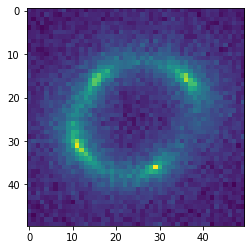

In [17]:
obs0, _, v0 = dataset[0]
samples_1d = posterior_1d.weighted_sample(100000, obs0)
plt.imshow(obs0['img'])

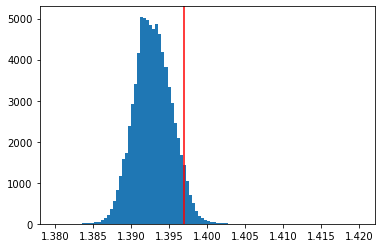

In [18]:
w = np.exp(samples_1d.weights[(0,)])
x = samples_1d.v[:,0]
plt.hist(x, weights=w, bins = 100);
plt.axvline(v0.item(), color='r')

In [19]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)

mu0 = obs0['img'].cpu().numpy()

def loglike(v):
    img = model(np.array([v]))['img']
    diff = img - mu0
    return 0.5*(diff**2).sum()/SIGMA**2

lls = np.array([loglike(v) for v in np.linspace(1.38, 1.42, 100)])

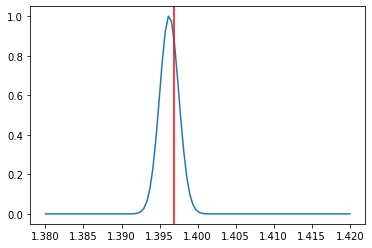

In [20]:
lls -= lls.min()
plt.plot(np.linspace(1.38, 1.42, 100), np.exp(-lls))
plt.axvline(v0.item(), color='r')